____________________________________________________________________

# NI-KOP

<p style='text-align: right;'> Author: Mykyta Boiko </p>
<p style='text-align: right;'> CTU login: boikomyk </p>

## Report #4

____________________________________________________________________

## Výběr algoritmu

Byly nabídnuté následující heuristické algoritmy:
- Simulované ochlazování

- Genetické algoritmy

- Tabu search

Pro řešení problému batohu jsem zvolil heruistiku **Simulované ochlazování**.

## Simulované ochlazování

#### Pseudokód (_přednaska č.8, str.14_)

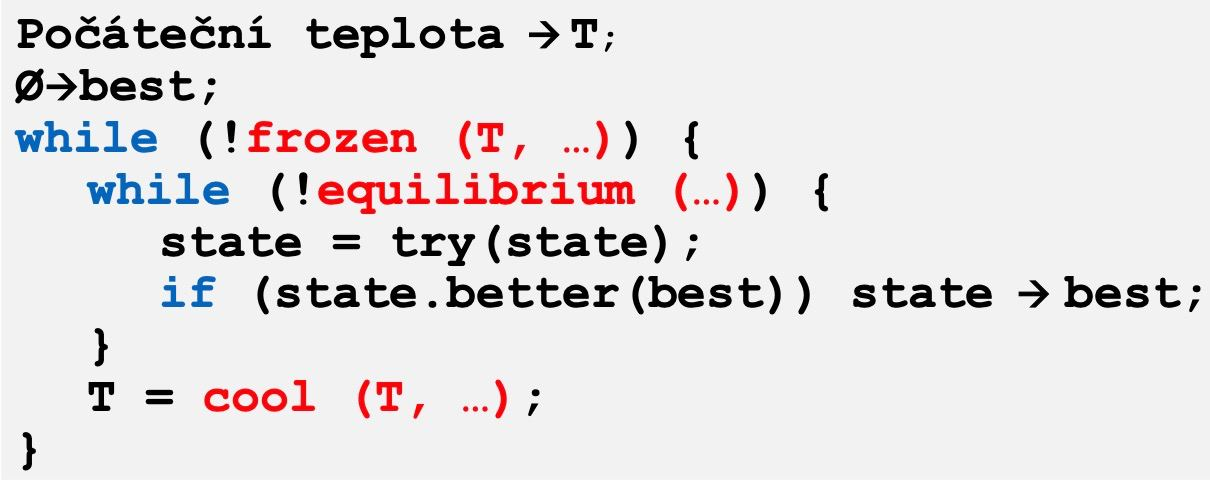

**Simulované ochlazování** je iterativní heruistika. Snaží se určitého počátečního řešení postupně dopracovat k řešení co nejlepšímu.

Zajimova vlasnost algoritmu je, že se snaží v jednotlivých iteracích uniknout z lokálního minima tím, že může dočasně přijmout horší výsledek. Algoritmus nezaručuje nalezení ideálně optimálního výsledků, přesto může za konstantní počet kroku najít docela příjemný výsledek.

Základní parametry algoritmu jsou:
- $\text{počáteční stav}$
- $\text{počáteční teplota}$
- $\text{koeficient ochlazování} \in [0.8,0.99]$
- $\text{koncová(/minimální) teplota}$
- $\text{equilibrium}$


Na začátku algoritmus dostane počáteční stav, t.j. libovolnou konfiguraci, která je řešením.
Algoritmus běží, dokud z počáteční teploty nedosáhne minimální teploty, ke které se dostává tak, že postupně násobí aktuální teplotu koeficientem ochlazování (aby aktuální teplota se zmenšovala). V algoritmu zmíněnou funkcionalitu implementuje fukce $\textbf{frozen()} $ (vnější cyklus).
Ochlazování teploty je implementované funkci $\textbf{cool()} $ na konci vnějšího cylku. Vnitřní cyklus je implementován funkci $\textbf{equilibrium()} $, která definuje pevný počet kroku, t.j. počet iteraci na daně teplotě, rovný: $ N_{CelkovyPocetVeci} * equilibrium $.

V každém kroku vnitřního cyklu je volaná funkce $\textbf{try()} $. Unvitr této funci generuje se _sousední stav_, t.j. sousední řešení(/konfigurace), která se liší jenom inverzi hanodneho bitů aktuálního stavu(t.j přidání resp. odebírání právě jedné věci).
Pokud je sousední stav lepší než aktuální, tak je vždy přijat. Pokud není, tak bude přijat na základě pravděpodobností danou formuli:
$$
\text{Pravděpodobnost přijetí} = e^{-\frac{CenaSousednihoStavu - AktualniCena}{AktualniTeplota}}
$$
Tato pravděpodobnost bude porovnána s náhodným číslem z intervalu $[0,1]$.
Z toho vlastně plynou následující zákonitosti: čím je horší řešení, tím je menší pravděpodobnost, že bude přijato. Avšak, čím je větší aktuální teplota, tím je větší šanci toho, že poměrně horší řešení bude přijato. Tohle právě znázorňuje princip uniknutí z lokálního minima.

Po ukončení vnitřního cyklu je snížena aktuální teplota. Pokud se došlo k minimální teplotě, tak algoritmus se zastaví a vrátí nalezeny výsledek.

Algoritmus je do detailů popsaný a okomentovaný přímo v kódu.

#### Zkrácený kód:
```python
        # repeat this process until the current temperature is less than the final temperature
        while not self._frozen():
            iteration = 0
            # stay on this temperature for a while (equilibrium)
            while self._equilibrium(iteration):
                # get a random neighbor of the current state
                self.state = self._try()

                if self.state.better(best_state) and self.state.is_valid():
                    # update best state
                    best_state = deepcopy(self.state)

                # increment counters
                iteration += 1

            # reduce the temperature on each iteration
            self.current_temperature = self._cool()
```

## Předzpracování a generování dát

Dále budou definované pomůcné funcke pro generování/načtení testovacích(vstupních) dát, řešení a vyklresleni výsledků experimentů.

In [1]:
# import scope
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict

%matplotlib inline

In [2]:
# path to solver executor
SOLVER = '../../knapsack/main_annealing.py'

In [3]:
!python3.9 $SOLVER --help | tail -n 20


Process input problem instances.

optional arguments:
  -h, --help            show this help message and exit
  -cnt COUNT, --count COUNT
  -in INPUT, --input INPUT
                        paste path to input files
  -ref REFERENCE, --reference REFERENCE
                        paste path with references
  -b, --benchmark       turn on/off benchmark
  -state_generator {InitialStateGenerator.empty,InitialStateGenerator.random,InitialStateGenerator.greedy}, --state_generator {InitialStateGenerator.empty,InitialStateGenerator.random,InitialStateGenerator.greedy}
  -initial_temperature INITIAL_TEMPERATURE, --initial_temperature INITIAL_TEMPERATURE
                        initial temperature
  -cooling_coefficient COOLING_COEFFICIENT, --cooling_coefficient COOLING_COEFFICIENT
                        cooling coefficient
  -minimal_temperature MINIMAL_TEMPERATURE, --minimal_temperature MINIMAL_TEMPERATURE
                        minimal temperature
  -equilibrium_coefficient EQUILIBRIUM_COEF

#### Základní nastavení parametrů algoritmu:

| |  |     |
|---:|:-------------|:-----------|
| 1 | Počáteční teplota  | 100       |
| 2 | Koeficient ochlazování  | 0.9    |
| 3 | Minimální teplota  | 10    |
| 4 | Equilibrium  | 3    |
| 5 | Generátor počátečního stavu  | empty |

Přidal jsem 5-tý parameter do algoritmu, který vlastně říká jak bude generovaný počáteční stav. Pro tyto účely jsem naimplementoval 3 možnosti:
- **empty**: prázdný batoh
- **random**: náhodně naplněný batoh
- **greedy**: batoh naplněný pomoci **Greedy** algoritmu

In [118]:
# common constants scope

INITIAL_TEMPERATURE = 100
COOLING_COEFFICIENT = 0.9
MINIMAL_TEMPERATURE = 10
EQUILIBRIUM = 3
INITIAL_STATE_GENERATOR = 'empty'


DEFAULT_ARGS = {
    '-initial_temperature'    : INITIAL_TEMPERATURE,
    '-cooling_coefficient'    : COOLING_COEFFICIENT,
    '-minimal_temperature'    : MINIMAL_TEMPERATURE,
    '-equilibrium_coefficient': EQUILIBRIUM,
    '-state_generator'        : INITIAL_STATE_GENERATOR
}

Měření se budou provádět na instanci velikosti $\textbf{40}$. Vstupni soubor **NK40_inst.dat**(soubor obsahuje 20 problémů.), referencni soubor **NK40_sol.dat**.


In [55]:
INPUT_FILE = 'NK40_inst.dat'
PATH_TO_INPUT_FILE = f'../../knapsack/data/task_2/NK/{INPUT_FILE}'
PATH_TO_REFERENCE  = f'../../knapsack/data/task_2/NK/' # it's enough to set only path to dir containing reference, program will find reference file by itself

In [15]:
# prepare help functions for data predprocessing
def read_and_store_buffer_input_to_df(buffer):
    # read csv input
    df = pd.read_table(buffer, delimiter="\t", index_col=False)
    return df

In [100]:
def solve_instance_using_simulated_annealing(
    parameter_with_range_to_test: Dict[str,str],
    args: Dict[str,str] = DEFAULT_ARGS,
    log_events = True
):  
    # remove from args tesing param
    parameter_name = next(iter(parameter_with_range_to_test.keys()))
    del args[parameter_name]
    
    # get valid args str
    args_str = " ".join(map(lambda arg: f"{arg[0]}={arg[1]}", args.items()))
    
    # prepare storage for algorithms outputs
    algorithm_outputs = {}

    algorithm_outputs = []
    for parameter_value in next(iter(parameter_with_range_to_test.values())):
        if log_events: print(f'\x1b[1;32m[INFO]\x1b[0m: testing parameter \x1b[1;31m {parameter_name}={parameter_value}\x1b[0m')

        # prepare args (inlcuding param to test)
        args_with_test_param = f'{args_str} {parameter_name}={parameter_value}'
        
        if log_events: print(f' - Solving input instance using algorithm', end='\n')
        # solve input instances using different alogrithms               
                            
        # solve input instace and obtain solution
        solution = !python3.9 $SOLVER -cnt=1 -in=$PATH_TO_INPUT_FILE -ref=$PATH_TO_REFERENCE -b $args_with_test_param

        # store solution output to dataframe
        df = read_and_store_buffer_input_to_df(
            buffer=StringIO(solution.n)
        )
        # update dataframe with corresponding column representing testing parameter
        df[parameter_name]=parameter_value
        algorithm_outputs.append(df)
            
    # concatenate all dataframes to single dataframe
    return pd.concat(algorithm_outputs).reset_index()

In [138]:
def plot_basic_analytics(
    algorithm_outputs: pd.DataFrame,
    index_column: str,
    parameter_label: str
):    
    # define several pivot tables for different analytic cases
    spawn_pivot_table = lambda value, aggfunc: pd.pivot_table(
        data=algorithm_outputs,
        values=value,
        index=index_column,
        aggfunc=np.mean
    )
    
    # Mean for: time, steps, error
    time_mean_table = spawn_pivot_table(value='TIME[ms]', aggfunc=np.mean)
    steps_mean_table = spawn_pivot_table(value='STEPS', aggfunc=np.mean)
    error_mean_table = spawn_pivot_table(value='ERROR', aggfunc=np.mean)
    
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

    ax = steps_mean_table.plot(title=f"Průměr počet kroků VS {parameter_label}", ax=axes[0])
    ax.set_ylabel('Průměr počtu kroků')
    ax.set_xlabel(parameter_label)

    ax = error_mean_table.plot(title=f"Průměr relativní chyby VS {parameter_label}", ax=axes[1])
    ax.set_ylabel('Průměr relativní chyby')
    ax.set_xlabel(parameter_label)


    ax = time_mean_table.plot(title=f"Průměr času v mikrosekundech VS {parameter_label}", figsize=(15,7))
    ax.set_ylabel('Průměr času v mikrosekundech')
    ax.set_xlabel(parameter_label)


    plt.show()

In [102]:
def plot_history_columns_evalution(
    algorithm_output: pd.DataFrame
):  
    history_table = pd.DataFrame(data={
        'PRICE_HISTORY': algorithm_output['PRICE_HISTORY'].iloc[0].split(','),
        'TEMPERATURE_HISTORY': algorithm_output['TEMPERATURE_HISTORY'].iloc[0].split(',')
    })
    # append STEPS column
    history_table["STEPS"] = history_table.index + 1
    
    
    # define several pivot tables for different analytic cases
    spawn_pivot_table = lambda value, aggfunc: pd.pivot_table(
        data=history_table,
        values=value,
        index='STEPS',
        aggfunc=np.mean
    )
    
    price_mean_table = spawn_pivot_table(value='PRICE_HISTORY', aggfunc=np.mean)
    temperatue_mean_table = spawn_pivot_table(value='TEMPERATURE_HISTORY', aggfunc=np.mean)
    
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

    ax = price_mean_table.plot(title=f"Vyvoj ceny VS Počet kroků", ax=axes[0])
    ax.set_ylabel('Vyvoj ceny')
    ax.set_xlabel('Počet kroků/Iterace')

    ax = temperatue_mean_table.plot(title=f"Vyvoj teploty VS Počet kroků", ax=axes[1])
    ax.set_ylabel('Vyvoj teploty')
    ax.set_xlabel('Počet kroků/Iterace')

    plt.show()

In [168]:
def plot_price_evalution_history(
    algorithm_output: pd.DataFrame,
    parameter_column_name: str,
    index_values
):
    index_values = index_values[:4]
    _, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
    
    x = 0
    y = 0
    for index_value in index_values:
        dataframe = algorithm_output.loc[algorithm_output[parameter_column_name] == index_value]
        
        price_history_table = pd.DataFrame(data={
            'PRICE_HISTORY': dataframe['PRICE_HISTORY'].iloc[0].split(','),
        })
        # append STEPS column
        price_history_table["STEPS"] = price_history_table.index + 1
        
        # define several pivot tables for different analytic cases
        spawn_pivot_table = lambda value, aggfunc: pd.pivot_table(
            data=price_history_table,
            values=value,
            index='STEPS',
            aggfunc=np.mean
        )
        price_mean_table = spawn_pivot_table(value='PRICE_HISTORY', aggfunc=np.mean)

        ax = price_mean_table.plot(title=f"{parameter_column_name}={index_value}", ax=axes[x, y])
        ax.set_ylabel('Vyvoj ceny')
        ax.set_xlabel('Počet kroků/Iterace')
        
        if y == 1:
            x = 1
            y = 0
        else:
            y += 1

    plt.suptitle('Vyvoj ceny VS Počet navštívených stavů/kroků',fontsize=18)

    plt.show()

## Analýza a interpretace dat

Jak již bylo zmíněno dříve, všechna měření se provádí na instanci velikosti $\textbf{40}$ s _20 problémy_ unvitř. 
Výsledky jsou zprůmerovany. Ve všech provedených měřeních vždy měníme pouze jeden parametr, ostatní zůstavají fixní.

### Závislosti kvality řešení a výpočetní náročnosti algoritmu na parametrech

#### Počáteční teplota [ $\textbf{-initial_temperature}$ ]

Následující test se zabývá citlivosti na počáteční teplotu **-𝐢𝐧𝐢𝐭𝐢𝐚𝐥_𝐭𝐞𝐦𝐩𝐞𝐫𝐚𝐭𝐮𝐫𝐞**.
Pro testování zvolíme interval $[0, 1000]$ s krokem 100.

In [134]:
args = DEFAULT_ARGS.copy()

initial_temperature_parameter = {
    # range -initial_temperature <0, 1000>
    '-initial_temperature': range(0, 1000 + 1, 100)
}

algorithm_outputs_initial_temperature = solve_instance_using_simulated_annealing(
    parameter_with_range_to_test=initial_temperature_parameter,
    args=args
)

[INFO]: testing parameter  -initial_temperature=0
 - Solving input instance using algorithm
[INFO]: testing parameter  -initial_temperature=100
 - Solving input instance using algorithm
[INFO]: testing parameter  -initial_temperature=200
 - Solving input instance using algorithm
[INFO]: testing parameter  -initial_temperature=300
 - Solving input instance using algorithm
[INFO]: testing parameter  -initial_temperature=400
 - Solving input instance using algorithm
[INFO]: testing parameter  -initial_temperature=500
 - Solving input instance using algorithm
[INFO]: testing parameter  -initial_temperature=600
 - Solving input instance using algorithm
[INFO]: testing parameter  -initial_temperature=700
 - Solving input instance using algorithm
[INFO]: testing parameter  -initial_temperature=800
 - Solving input instance using algorithm
[INFO]: testing parameter  -initial_temperature=900
 - Solving input instance using algorithm
[INFO]: testing parameter  -initial_temperature=1000
 - Solvin

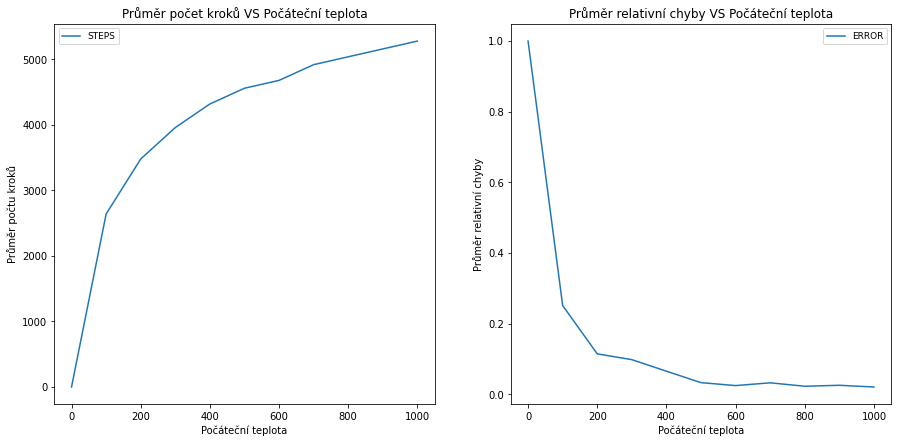

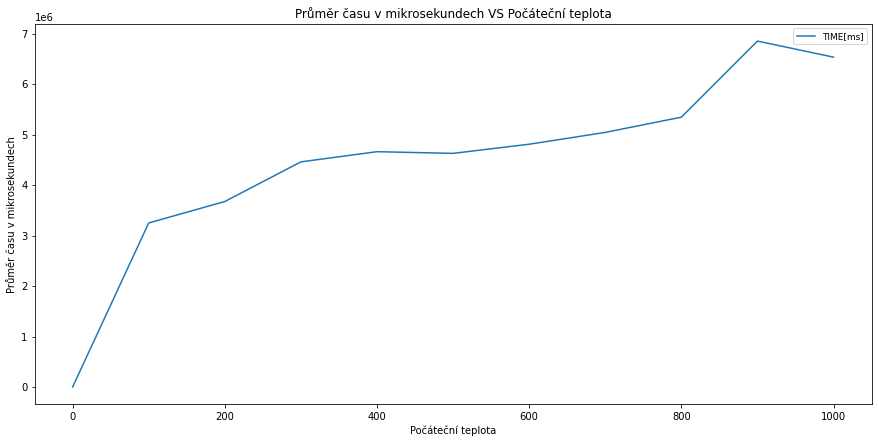

In [139]:
plot_basic_analytics(
    algorithm_outputs=algorithm_outputs_initial_temperature,
    index_column=next(iter(initial_temperature_parameter)),
    parameter_label='Počáteční teplota'
)

Probereme a provedeme analýzu vykreslených grafů.

##### $\textbf{- Počet navštívených stavů:}$
Z grafu je vidět, že při zvyšování počáteční teploty, roste počet prohledovanych stavu. Stejně tak, stojí za zmínku, že koeficient ochlazování se nemění, proto je logicky, že roste počet kroku abychom se dostali na minimální teplotu.

##### $\textbf{- Relativní chyba:}$
Čím větší hodnota počáteční teploty, tím je větší šance u algorimu opustit oblast lokálního minima, neboť zvyšuje pravděpodobnost přijetí horšího řešení. Relativní chyba se snižuje s vyšší počáteční teplotou a dá se říct, že dosahujeme lepších výsledků. Ale stojí za povšimnutí, že na začátku hodnota relativní chyby významné klesá a pak někde kolem _500_ se začíná konstantní vývoj.

##### $\textbf{- Časová složitost:}$
Počáteční teplota, stejně jak minimální teplota, má přímý vliv na počet iteraci vnějšího cyklu. Je vidět, že s věští hodnotou počáteční teploty roste i čas. Nejdříve je růst významný, ale po čase se trochu uklidní.

##### Vývoj ceny/teploty v zavislosti na počtu navštívených stavů

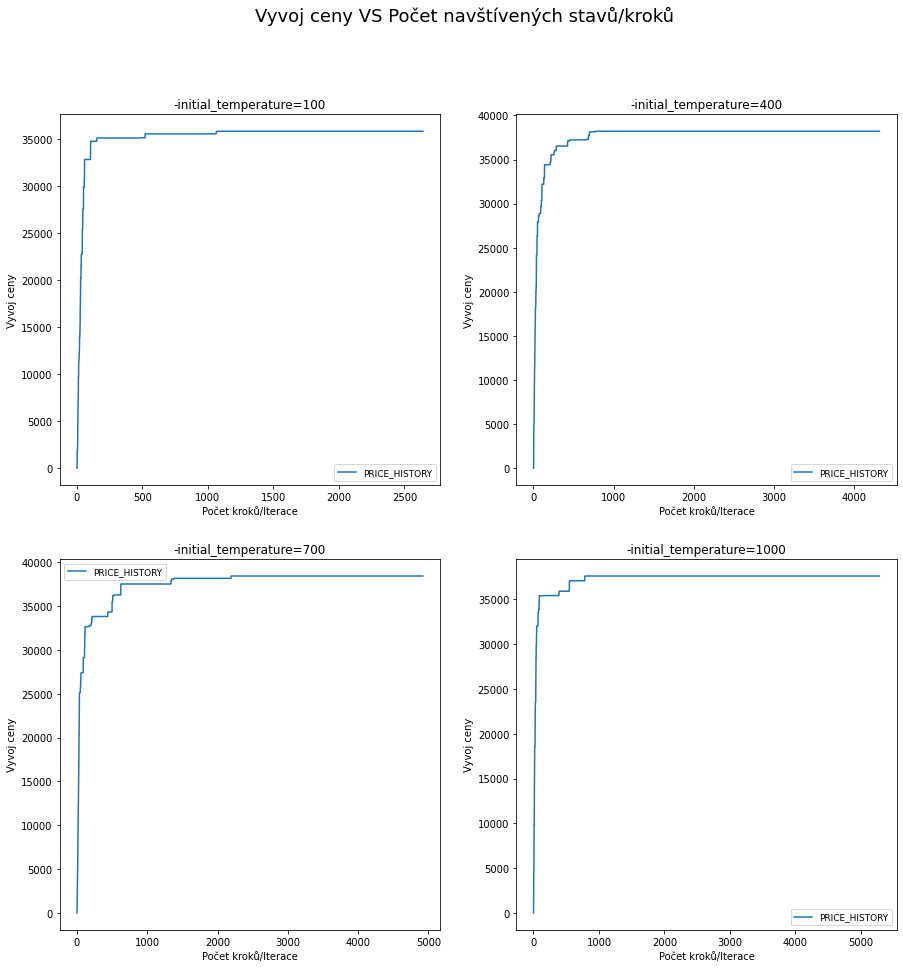

In [169]:
plot_price_evalution_history(
    algorithm_output=algorithm_outputs_initial_temperature,
    parameter_column_name='-initial_temperature',
    index_values=[100, 400, 700, 1000]
)

#### Koeficient ochlazování [ $\textbf{-cooling_coefficient}$ ]

Následující test se zabývá citlivosti na koeficient ochlazování **-cooling_coefficient**.
Pro testování zvolíme interval $[0,8, 0.99]$ s krokem 0.01.

In [140]:
args = DEFAULT_ARGS.copy()

cooling_coefficient_parameter = {
    # range -initial_temperature <0.8, 0.99>
    '-cooling_coefficient': np.round(np.arange(0.8, 0.99 + 0.01, 0.01), 2)
}

algorithm_outputs_cooling_coefficient = solve_instance_using_simulated_annealing(
    parameter_with_range_to_test=cooling_coefficient_parameter,
    args=args
)

[INFO]: testing parameter  -cooling_coefficient=0.8
 - Solving input instance using algorithm
[INFO]: testing parameter  -cooling_coefficient=0.81
 - Solving input instance using algorithm
[INFO]: testing parameter  -cooling_coefficient=0.82
 - Solving input instance using algorithm
[INFO]: testing parameter  -cooling_coefficient=0.83
 - Solving input instance using algorithm
[INFO]: testing parameter  -cooling_coefficient=0.84
 - Solving input instance using algorithm
[INFO]: testing parameter  -cooling_coefficient=0.85
 - Solving input instance using algorithm
[INFO]: testing parameter  -cooling_coefficient=0.86
 - Solving input instance using algorithm
[INFO]: testing parameter  -cooling_coefficient=0.87
 - Solving input instance using algorithm
[INFO]: testing parameter  -cooling_coefficient=0.88
 - Solving input instance using algorithm
[INFO]: testing parameter  -cooling_coefficient=0.89
 - Solving input instance using algorithm
[INFO]: testing parameter  -cooling_coefficient=0.9

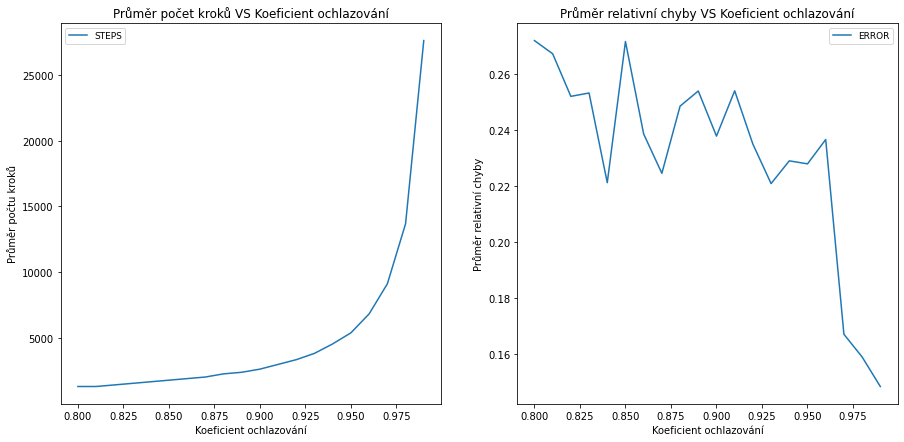

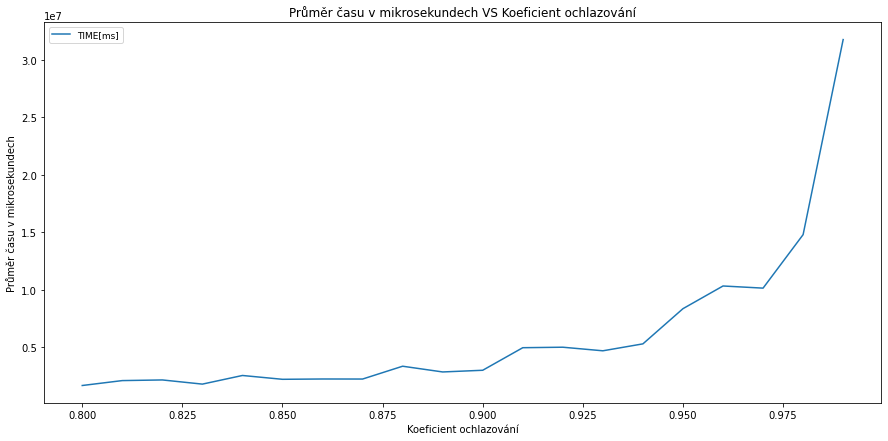

In [141]:
plot_basic_analytics(
    algorithm_outputs=algorithm_outputs_cooling_coefficient,
    index_column=next(iter(cooling_coefficient_parameter)),
    parameter_label='Koeficient ochlazování'
)

Probereme a provedeme analýzu vykreslených grafů.

##### $\textbf{- Počet navštívených stavů:}$
Z grafu je vidět, že s rostoucí hodnotou koeficientu ochlazování roste počet prohledovanych stavu. Taky je dá se říct, že průběh je polynomiální. Pro hodnoty blízké k 1 je už nárůst počtu stavu exponenciální.

##### $\textbf{- Relativní chyba:}$
Kvalita řešení mírně roste. Průměrné klesá relativní chyba výsledků s rosotuci hodnotou koeficientu ohlazování.

##### $\textbf{- Časová složitost:}$
S rostoucím koeficientem ochlazování roste i časová narocnot. Stejně jak u grafu pročtu prozkoumaných stavu, dá se říct, že pro hodnoty blízké k 1 je už růst skoro exponecnialni.

##### Vývoj ceny/teploty v zavislosti na počtu navštívených stavů

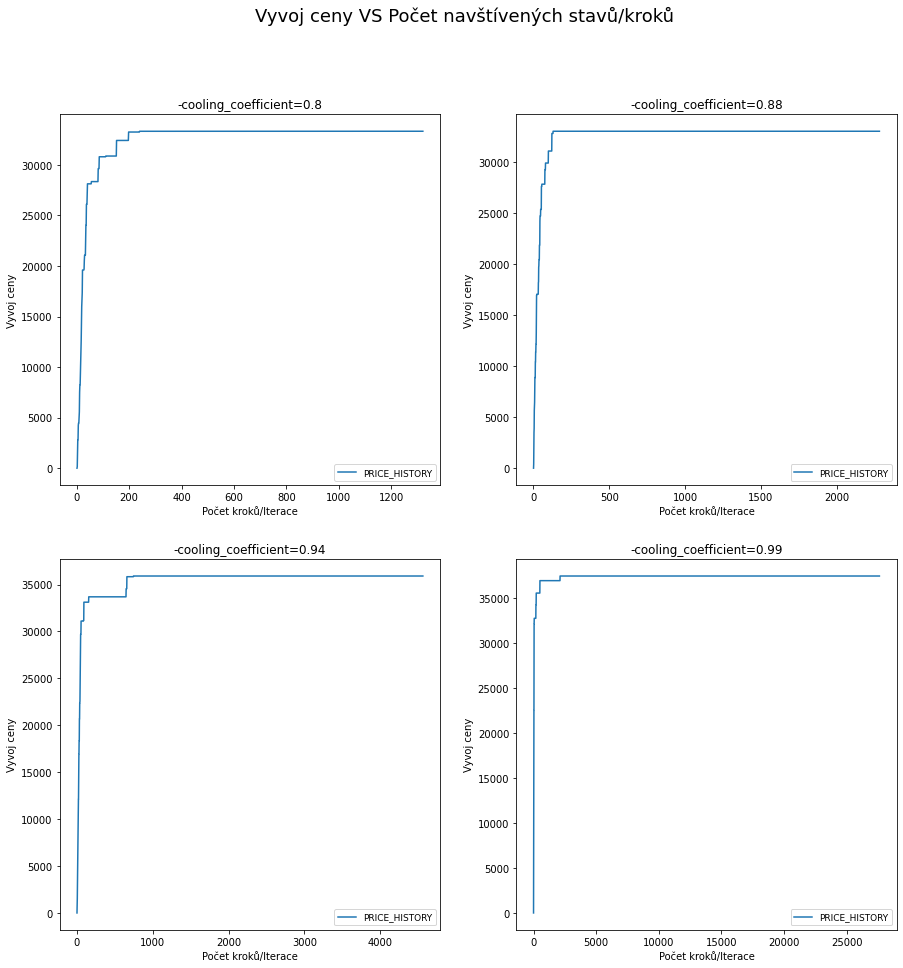

In [171]:
plot_price_evalution_history(
    algorithm_output=algorithm_outputs_cooling_coefficient,
    parameter_column_name='-cooling_coefficient',
    index_values=[0.8, 0.88, 0.94, 0.99]
)

#### Minimální teplota [ $\textbf{-minimal_temperature}$ ]

Následující test se zabývá citlivosti na hodnotu nastavené miminalni teploty **-minimal_temperature**.
Pro testování zvolíme interval $[1, 99]$ s krokem 5.

In [144]:
args = DEFAULT_ARGS.copy()

minimal_temperature_parameter = {
    # range -minimal_temperature <1, 99>
    '-minimal_temperature': range(1, 99 + 1, 5)
}


algorithm_outputs_minimal_temperature_parameter = solve_instance_using_simulated_annealing(
    parameter_with_range_to_test=minimal_temperature_parameter,
    args=args
)

[INFO]: testing parameter  -minimal_temperature=1
 - Solving input instance using algorithm
[INFO]: testing parameter  -minimal_temperature=6
 - Solving input instance using algorithm
[INFO]: testing parameter  -minimal_temperature=11
 - Solving input instance using algorithm
[INFO]: testing parameter  -minimal_temperature=16
 - Solving input instance using algorithm
[INFO]: testing parameter  -minimal_temperature=21
 - Solving input instance using algorithm
[INFO]: testing parameter  -minimal_temperature=26
 - Solving input instance using algorithm
[INFO]: testing parameter  -minimal_temperature=31
 - Solving input instance using algorithm
[INFO]: testing parameter  -minimal_temperature=36
 - Solving input instance using algorithm
[INFO]: testing parameter  -minimal_temperature=41
 - Solving input instance using algorithm
[INFO]: testing parameter  -minimal_temperature=46
 - Solving input instance using algorithm
[INFO]: testing parameter  -minimal_temperature=51
 - Solving input inst

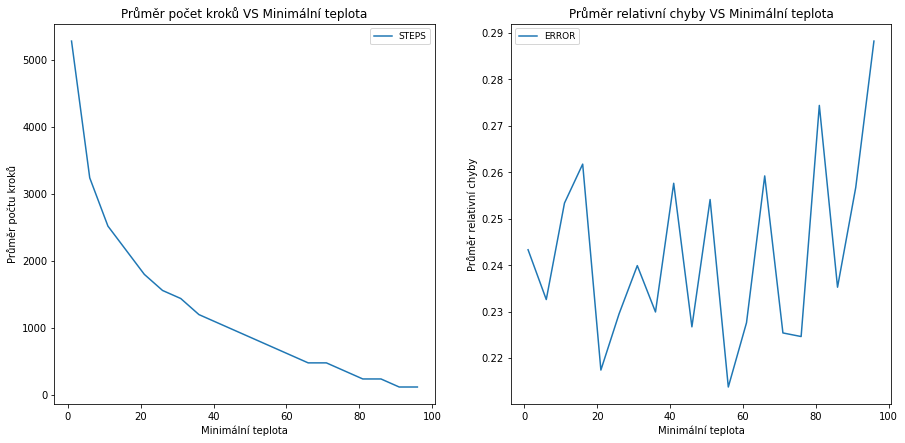

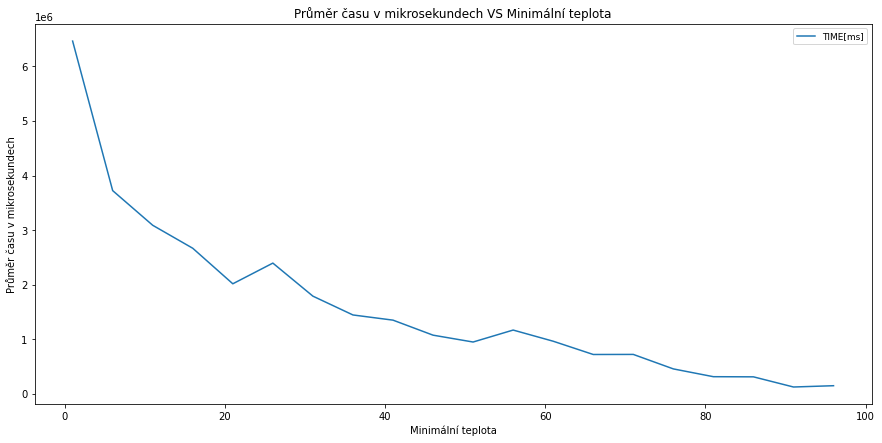

In [146]:
plot_basic_analytics(
    algorithm_outputs=algorithm_outputs_minimal_temperature_parameter,
    index_column=next(iter(minimal_temperature_parameter)),
    parameter_label='Minimální teplota'
)

Probereme a provedeme analýzu vykreslených grafů.

##### $\textbf{- Počet navštívených stavů:}$
Je jasný, že se zvýšením minimlani teploty zastavíme algoritmus dříve, neboť parameter má přímý vliv na vnější cyklus algoritmu. Zmenšuje se stavový prostor, který prohledáváme.

##### $\textbf{- Relativní chyba:}$
Vývoj relativní chyby je docela divný. Vypadá, že na zkoumaném intervalu minimální teplota nemá vliv na kvalitu řešení. Avšak jediné co jde říct, že u teplot se blížících počáteční teplotě relativní chyba je větší, neboť zastavujeme algoritmus příliš brzo, neproběhne ještě dostatek iteraci pro nalezení lepších řešení a jsou přijímána horší řešení.

##### $\textbf{- Časová složitost:}$
Stejně jak u grafu počtu navštívených stavů se zvýšením minimální teplty zmenšuje se doba výpočtu.

##### Vývoj ceny/teploty v zavislosti na počtu navštívených stavů

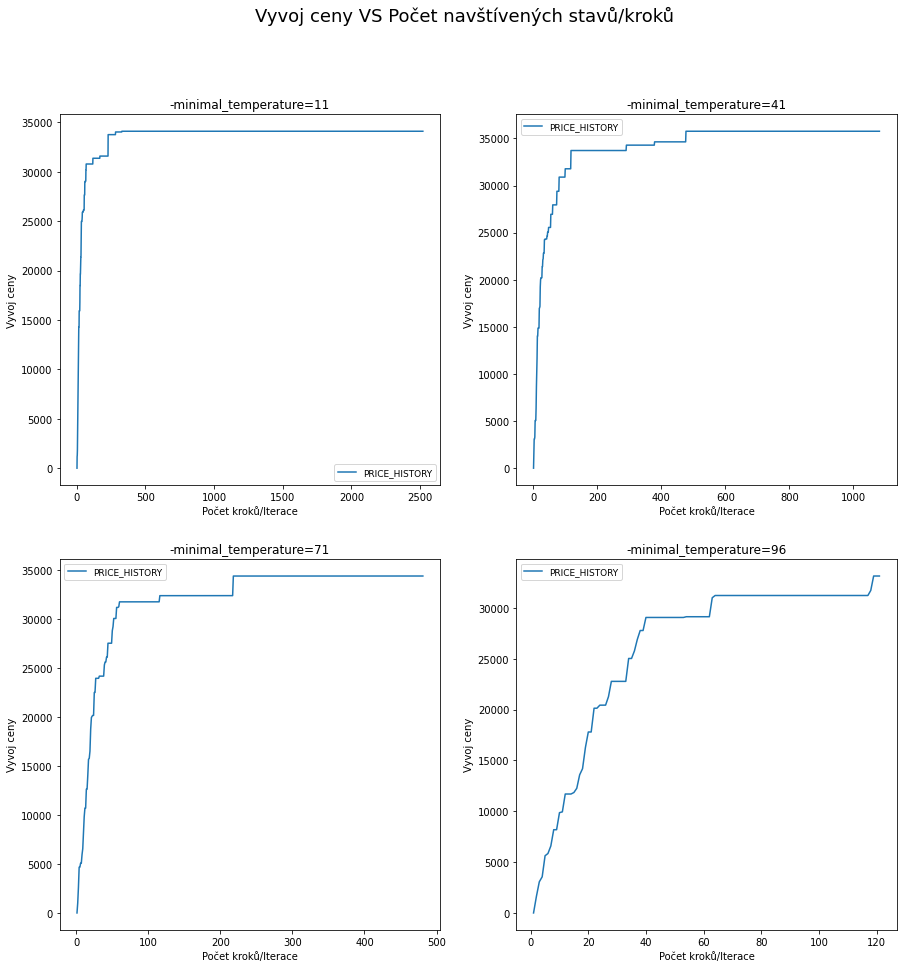

In [174]:
plot_price_evalution_history(
    algorithm_output=algorithm_outputs_minimal_temperature_parameter,
    parameter_column_name='-minimal_temperature',
    index_values=[11, 41, 71, 96]
)

#### Equilibrium [ $\textbf{-equilibrium_coefficient}$ ]

Následující test se zabývá citlivosti na equilibriu **-equilibrium_coefficient**.
Pro testování zvolíme interval $[0, 100]$ s krokem 10.

In [147]:
args = DEFAULT_ARGS.copy()

equilibrium_parameter = {
    # range -minimal_temperature <1, 99>
    '-equilibrium_coefficient': range(0, 100 + 1, 10)
}


algorithm_outputs_equilibrium = solve_instance_using_simulated_annealing(
    parameter_with_range_to_test=equilibrium_parameter,
    args=args
)

[INFO]: testing parameter  -equilibrium_coefficient=0
 - Solving input instance using algorithm
[INFO]: testing parameter  -equilibrium_coefficient=10
 - Solving input instance using algorithm
[INFO]: testing parameter  -equilibrium_coefficient=20
 - Solving input instance using algorithm
[INFO]: testing parameter  -equilibrium_coefficient=30
 - Solving input instance using algorithm
[INFO]: testing parameter  -equilibrium_coefficient=40
 - Solving input instance using algorithm
[INFO]: testing parameter  -equilibrium_coefficient=50
 - Solving input instance using algorithm
[INFO]: testing parameter  -equilibrium_coefficient=60
 - Solving input instance using algorithm
[INFO]: testing parameter  -equilibrium_coefficient=70
 - Solving input instance using algorithm
[INFO]: testing parameter  -equilibrium_coefficient=80
 - Solving input instance using algorithm
[INFO]: testing parameter  -equilibrium_coefficient=90
 - Solving input instance using algorithm
[INFO]: testing parameter  -equ

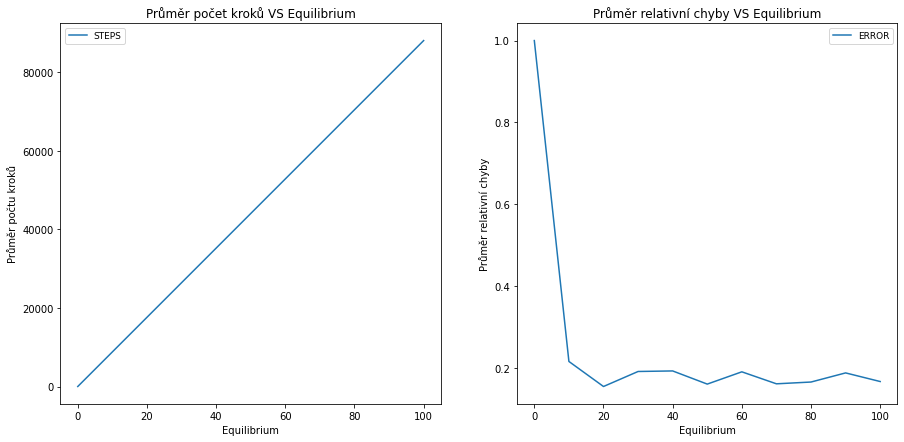

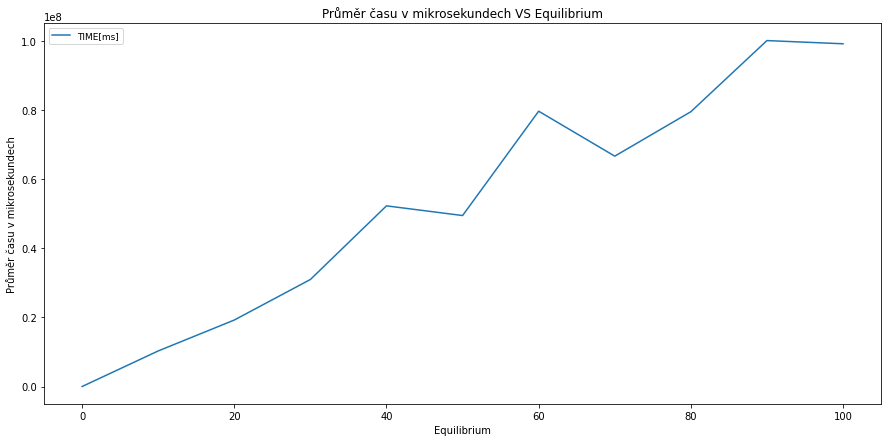

In [150]:
plot_basic_analytics(
    algorithm_outputs=algorithm_outputs_equilibrium,
    index_column=next(iter(equilibrium_parameter)),
    parameter_label='Equilibrium'
)

Probereme a provedeme analýzu vykreslených grafů.

##### $\textbf{- Počet navštívených stavů:}$
Co by šlo říct z prvního pohledu na graf, tak že je viditelná lineární závislost počtu navštívených stavu na equilibriu, neboť roste počet provedení vnitřního cyklu.

##### $\textbf{- Relativní chyba:}$
S rostoucí hodnotou equilibria roste složitost algoritmu, stejně tak i roste počet nalezených řešení. Příliš malá hodnota omezuje počet generovaných stavu. Je viditelně, že equilibrium má značný vliv na relativní chybu. S rostoucím koeficientem equilibria klesá relativní chyba. Závislost chyby na equilibriu vypadá jako exponenciální. Avšak od hodnoty _20_ se relativní chyby skoro nemění.

##### $\textbf{- Časová složitost:}$
Vlastně tady pozorujeme to samé, co i na grafu počtu navštívených stavu. Časová složitost s velikosti equilibria roste lineárně. Divne vychylky na grafu jsou nejspis kluli přetížení počítače (v důsledku zatížení RAM nebo něco podobného).

##### Vývoj ceny/teploty v zavislosti na počtu navštívených stavů

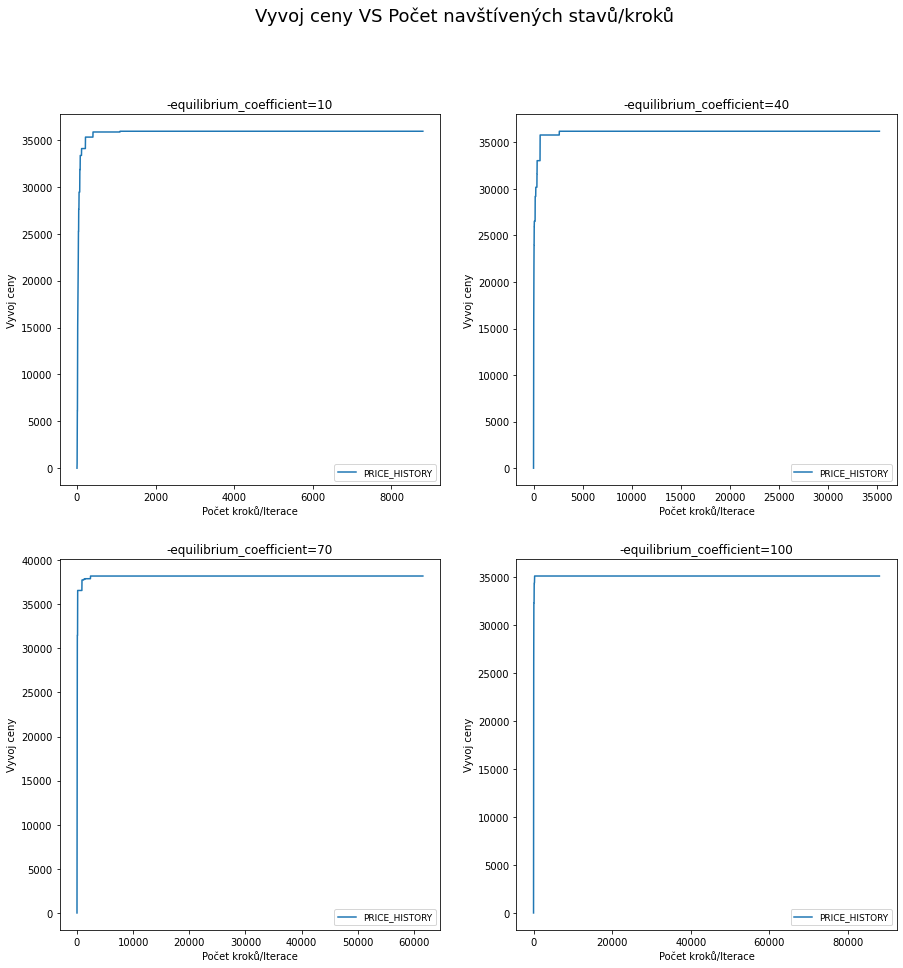

In [177]:
plot_price_evalution_history(
    algorithm_output=algorithm_outputs_equilibrium,
    parameter_column_name='-equilibrium_coefficient',
    index_values=[10, 40, 70, 100]
)

### Volba počátečního stavu

Jak jsem již zmiňoval dříve, naiplementoval jsem několik možnosti volby počátečního stavu.
Je jasný, že volba pocatechniho stavu nemá žádný vliv na čas běhu algoritmu a počet prozkoumaných stavu.

Provedeme pár experimentu a zjistíme, jestli způsob generování počátečního stavu má nějaký vliv výslednou kvalitu řešení.

In [189]:
AVAILABLE_STATES = ['empty', 'random', 'greedy']

args = DEFAULT_ARGS.copy()
state_generator_parameter = {
    '-state_generator': AVAILABLE_STATES
}

algorithm_outputs_state_generator_parameter = solve_instance_using_simulated_annealing(
    parameter_with_range_to_test=state_generator_parameter,
    args=args
)

[INFO]: testing parameter  -state_generator=empty
 - Solving input instance using algorithm
[INFO]: testing parameter  -state_generator=random
 - Solving input instance using algorithm
[INFO]: testing parameter  -state_generator=greedy
 - Solving input instance using algorithm


#### Vývoj ceny/teploty v zavisloti na počtu navštívených stavů

======================================== state generator = EMPTY ========================================


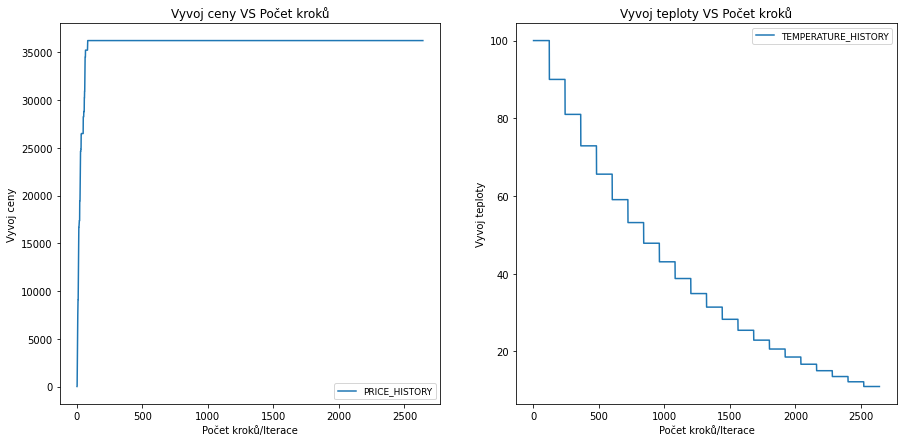

======================================== state generator = RANDOM ========================================


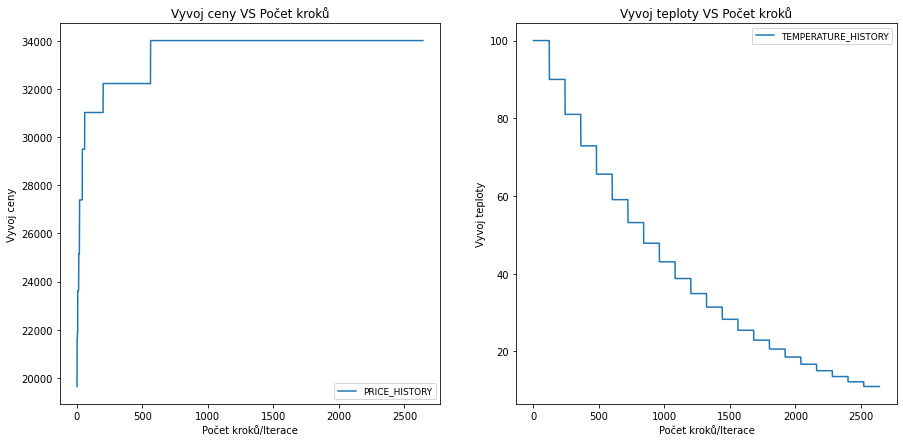

======================================== state generator = GREEDY ========================================


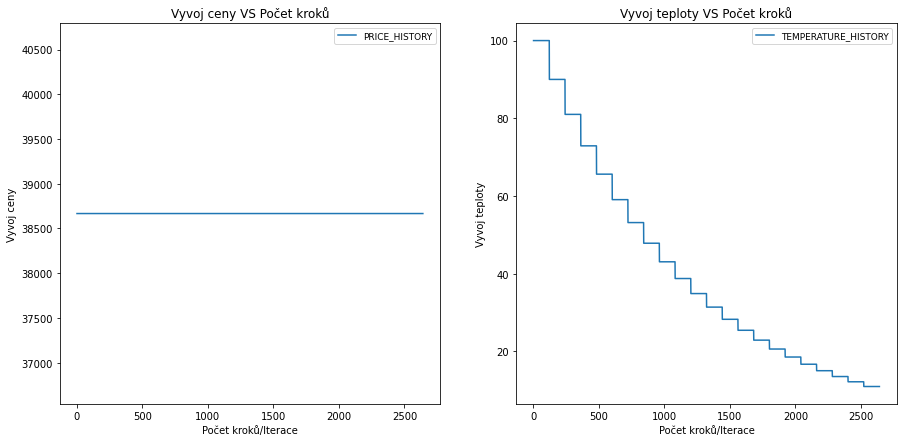

In [192]:
for state_generator in AVAILABLE_STATES:
    print("="*40, "state generator =", state_generator.upper(), "="*40)
    
    plot_history_columns_evalution(
        algorithm_output=algorithm_outputs_state_generator_parameter.loc[algorithm_outputs_state_generator_parameter['-state_generator'] == state_generator]
    )

Vidíme, že výsledná cena je na všech grafech je stejná.

**Greedy** se povedlo hned vygenerovat optimální řešení, proto vývoj ceny je konstantní. Dá se říct, kvalita řešení není moc závislá na způsobu generování počátečního stavu. Nemělo by dojít k výraznému zlepšení výsledků.

## Závěr

Algoritmus simulovaného ochlazování je poměrně snadný na implementaci. Z provedených experimentu je vidět, že není přišili vhodný na řešení problémů batohu. 

Je docela časově náročný. Algortmus skoro nezávisí na tom, jakým způsobem bude vygenerován počáteční stav. T.j. pokud inicializujeme algoritmus stavem generovaným **Greedy** heruistikou, tak by nemělo dojít k výraznému zlepšení vysledku.

Exporimenty s nastavováním parametrů u algoritmu byly docela časově náročné. Ale zjistily se zajímavé věci. Například nedává smysl nastavovat příliš vysoké hodnoty u parametrů počáteční teplota a equilibria, neboť při větších hodnotách již nedochází ke zlepšení výsledků, a doba běhu se zvětšuje. Taky nemá cenu nastavovat příliš nízkou hodnotu miminalni teploty a equilibria.

Stejně tak u koeficientu ochlazování od určitého bodů dochází v velkému nárůstu navštívených stavu, avšak relativní chyba už moc neklesá.

Dá se říct, že při dobrém nastavení parametrů se dá dosáhnout příjemných výsledků.